<a href="https://colab.research.google.com/github/raqueeb/TensorFlow2/blob/master/GAP_cnn_tf3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ‘কনভলিউশনাল নিউরাল নেটওয়ার্ক’ এবং গ্লোবাল অ্যাভারেজ পুলিং

আমরা যখন ‘কনভলিউশনাল নিউরাল নেটওয়ার্ক’ নিয়ে কাজ করলাম, তখন একটা জিনিস বোঝা গেল আমাদের শেষ লেয়ারগুলোতে আমরা ‘ফুললি কানেক্টেড লেয়ার’গুলোর কিছু ভ্যারাইটি পেয়েছি। মানে শেষ লেয়ারে আমরা একটা স্ট্যান্ডার্ড নিউরাল নেটওয়ার্ককে যোগ করে দিতে পেরেছি। ‘সিএনএন’ অথবা কনভলিউশনাল নিউরাল নেটওয়ার্কের যে কয়েকটা এলিমেন্ট আছে সেগুলো নিয়ে আমরা দেখিয়েছি আগের চ্যাপ্টারগুলোতে। আপনি যদি ভালোভাবে দেখেন তাহলে মনে হবে এই কনভলিউশন মানে একটা ‘ইমেজ প্রসেসর’ - এর পরে একটা ‘স্ট্যান্ডার্ড নিউরাল নেটওয়ার্ক ক্লাসিফায়ার’কে যোগ করে দিয়েছি। আমাদের এই কনভলিউশনাল নিউরাল নেটওয়ার্ক বেশ কয়েকটা কনভলিউশনাল লেয়ার দিয়ে শুরু হয় যার মধ্যে ‘কার্নাল কনভলিউশন’ এবং ‘ম্যাক্স কুলিং’ অনেকগুলো ফিচার ম্যাপ তৈরি করে দেয় যেটা ছবির বিভিন্ন কম্পোনেন্ট এর রিপ্রেজেন্টেশন নিয়ে আসে। 

সবশেষে এই ‘ফুললি কানেক্টেড লেয়ার’ ওই ফিচার ম্যাপগুলোকে এমনভাবে ইন্টারপ্রেট করে যাতে তারা দরকার মতো ‘ক্যাটেগরি’ প্রেডিকশন করতে পারে। ভালো কথা, জিনিসটা এভাবেই চলছিল অনেকদিন - তবে এই ডিপ লার্নিং রিসার্চের যুগে এই জিনিসটাকে পাশ কাটিয়ে চলে আসে আরেকটা কনসেপ্ট যেটাকে আমরা বলছি ‘গ্লোবাল অ্যাভারেজ পুলিং’। এই ‘গ্লোবাল এভারেজ পুলিং’ করতে গেলে আমাদেরকে একটা ‘সিএনএন’ নেটওয়ার্ক তৈরি করে দেখাতে হবে। এরপর, আমরা সেখানে কিছুটা এডজাস্টমেন্ট করব তখনই বুঝে যাবেন কেন দরকার পড়ছে এই ‘গ্লোবাল অ্যাভারেজ পুলিং’। দুটো ‘প্রি-ট্রেইনড’ উদাহরণ দেখি। প্রথমটা VGG-16 মডেল। এটার একটা ছবি দেখি। 
<img src="https://raw.githubusercontent.com/raqueeb/deep_learning_book/master/assets/vgg.png"> চিত্রঃ VGG-16 মডেল


In [1]:
try:
  # শুধুমাত্র টেন্সর-ফ্লো ২.x ব্যবহার করবো 
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


## প্রি-ট্রেইনড মডেল VGG16 এর লেয়ার

In [2]:
# from tensorflow.keras import layers

from tensorflow.keras.applications.vgg16 import VGG16; VGG16().summary()

553467904/553467096 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

## প্রি-ট্রেইনড মডেল ResNet-50 এর লেয়ার

কি দেখলাম? অনেকগুুলো কনভলিউশন নেটওয়ার্ক, ম্যাক্স পুলিং, আর শেষে তিনটা ডেন্স কানেক্টেড লেয়ার। বাকি আর কিছু বলছিনা এখন। দেখি আরেকটা নেটওয়ার্ক। 

পরেরটা ResNet-50, কি পার্থক্য দেখলাম?


In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50; ResNet50().summary()

102973440/102967424 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

কি দেখলেন? শেষ আউটপুট লেয়ারের আগে একটা নতুন এন্ট্রি 'avg_pool (GlobalAveragePooling2D)', চলুন আলাপ করি। শুরুতেই আরেকটা ডেটাসেট, সিএনএন দিয়ে।  

এই নতুন নেটওয়ার্ক তৈরি করতে আজকে আমরা ব্যবহার করব আরেকটা নতুন ডাটাসেট,যা বেশিরভাগ ডিপ লার্নিং এক্সপার্ট ব্যবহার করেছেন তার শেখার শুরুতে। বেড়াল এবং কুকুরের ছবিকে ঠিকমতো ক্লাসিফাই করার জন্য এই ডাটাসেটটা ব্যবহার শুরু হয় সেই ২০১৩ সালে। এর শুরুটা হয় একটা ক্যাগল মেশিন লার্নিং কম্পিটিশনে। এই কাজের পেছনে ছিল মাইক্রোসফট এবং পেট ফাইন্ডার বলে একটা কোম্পানির পার্টনারশিপ। আমরা যে ডাটাসেটটা ব্যবহার করব সেটা প্রায় ৩০ লক্ষ ছবির একটা ম্যানুয়াল ‘লেবেলড’ ডাটাবেজ। মানুষ নিজে হাতে করেছে। তবে আমরা সেটার একটা ‘সাবসেট’ ব্যবহার করব যার জন্য এত ছবি না হলেও চলে। শুরুতে আমরা একটা স্ট্যান্ডার্ড ‘সিএনএন’ তৈরি করলেও তার শেষে গ্লোবাল অ্যাভারেজ পুলিং অংশটুকু জুড়ে দেব আপনাদের বোঝার জন্য। আমাদেরকে একটা ছবি দিয়ে বলতে হবে সেটা আসলে একটা বিড়ালের না কুকুরের ছবি? এবং সেটার অ্যাক্যুরেসি সাধারণ ‘সিএনএন’  থেকে কতো ভালো?

In [0]:
# লোড করে নেই হেল্পার লাইব্রেরি, টেন্সর-ফ্লো ডেটাসেট এপিআই

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import datetime as dt

## গ্লোবাল অ্যাভারেজ পুলিং

আমরা যখন এক লেয়ার থেকে আরেক লেয়ারে ডাটা পাঠাই, তখন লেয়ার ভিত্তিক ক্যালকুলেশনে যদি এমন কিছু করতে পারি যাতে সামনের দিকের ডাটাগুলো কমে আসে। এটা ভালো হবে না? এমনিতেই একেকটা নিউরাল নেটওয়ার্ককে ট্রেইন করতে যে সময় লাগে, তার পাশাপাশি সেই কম্পিউটিং রিসোর্স জোগাড় করা যেরকম কষ্টকর - সেই দিক থেকে বিবেচনা করতে গেলে ‘গ্লোবাল অ্যাভারেজ পুলিং’ আগের লেয়ারের প্রতিটা ফিচার ম্যাপের আউটপুটের গড়কে ক্যালকুলেট করে পাঠায় সামনের লেয়ারে। এই সহজ কাজটা আমাদের ডাটা ফ্লোকে অনেকটাই কমিয়ে নিয়ে আসে আমাদের শেষ ক্লাসিফিকেশন লেয়ারের জন্য। এতে ট্রেনিং দেবার মতো আর কোন প্যারামিটার থাকেনা, কিছুটা ম্যাক্স পুলিং এর মতো। আমরা এখানে একটা ছবি দেখতে পারি।

<img src="https://raw.githubusercontent.com/raqueeb/deep_learning_book/master/assets/gap1.png"> চিত্রঃ ‘গ্লোবাল অ্যাভারেজ পুলিং’ লেয়ার চলে আসছে আউটপুটের আগের লেয়ারে

আপনারা দেখুন - সবশেষ লেয়ারে যেখানে আমরা জিনিসপত্র ক্লাসিফাই করছি তার আগেই এই গ্লোবাল এভারেজ পুলিং লেয়ারটা দেখতে পাচ্ছি। সেটা থেকে আউটপুট চলে যাচ্ছে আগের মত সফটম্যাক্স লেয়ারে। আমাদের এই আর্কিটেকচারে ৬৪টা গড় ক্যালকুলেশন আসছে সেই ৬৪ এবং ৭ x ৭ চ্যানেল থেকে - যেটা আমরা দেখছি দ্বিতীয় কনভলিউশনাল লেয়ারের আউটপুট থেকে আসছে। আমাদের এই ‘গ্যাপ’ মানে ‘গ্লোবাল অ্যাভারেজ পুলিং’ লেয়ার আগের ৭ x ৭, ৬৪ ডাইমেনশন থেকে ১ x ১, ৬৪ ডাইমেনশনে যা আসলে আসছে ৭ x ৭ চ্যানেলের গড় আউটপুট থেকে। অনেকে বলতে পারেন শেষের ‘ফুললি কানেক্টেড লেয়ারগুলো থেকে গ্লোবাল অ্যাভারেজ পুলিং লেয়ার কেন ভালো? 

১. সবচেয়ে বড় কথা হচ্ছে আমরা মডেলের শেষ লেয়ারগুলোতে ট্রেনিং করার মত প্যারামিটারগুলোকে বাদ দিয়ে দিচ্ছি। একটা ‘ফুললি কানেক্টেড’ অথবা ‘ডেন্স’ লেয়ারে প্রচুর প্যারামিটার থাকে সেখানে আমাদের আগের ছবিতে একটা ৭ x ৭, ৬৪ ডাইমেনশনের ‘সিএনএন’ আউটপুটকে প্ল্যান করে সেটাকে ঢুকিয়ে দেয়া হচ্ছে ৫০০ নোডের একটা ডেন্স লেয়ারে যেটা প্রায় ১৫ কোটি ‘ওয়েট’ বের করে দিচ্ছে আমাদের ট্রেনিংয়ের জন্য। এটা একটা বিশাল কাজের লোড। এই জিনিসগুলোকে বাদ দেয়াতে আমাদের ট্রেনিং স্পিড বেড়ে যাবে অনেক গুন। 

২. যেহেতু আমরা এতগুলো ট্রেনিং দেবার মতো প্যারামিটারগুলোকে ফেলে দিচ্ছি সেটা অনেকটাই কমিয়ে দেবে ‘ওভার ফিটিং’। সেখানে আমরা ‘ফুললি কানেক্টেড’ লেয়ারে ড্রপ আউট ব্যবহার করা যেতো। ‘ড্রপ আউট’ নিয়ে আলোচনা করা যাবে সামনে। 

৩. ‘গ্লোবাল অ্যাভারেজ পুলিং’ নিয়ে প্রচুর আলাপ হয়েছে রিসার্চে। দেখা গেছে আমরা যদি এই ‘ফুললি কানেক্টেড ক্লাসিফিকেশন লেয়ার ফেলে দেই তাহলে ফিচার ম্যাপগুলো খুব কাছাকাছি কাজ করতে পারে তাদের ক্লাসিফিকেশন ক্যাটেগরি বানানোর জন্য। কিছুটা ডাইরেক্ট কানেকশন। এখানে আমরা বলতে পারি আমাদের প্রতিটা ফিচার ম্যাপ একেকটা ক্যাটেগরির ‘কনফিডেন্স ম্যাপ’ হিসেবে দাঁড়িয়ে গেছে।

৪. সবচেয়ে বড় কথা হচ্ছে ফিচার ম্যাপগুলোর গড় অপারেশন আমাদের মডেলকে আরো শক্তিশালী করে তুলছে ডাটার ভেতরের ইন্টারনাল ট্রান্সলেশন কাছাকাছি হবার কারণে। যতক্ষণ দরকারি ফিচারগুলোকে যোগ করা বা এক্টিভেট করা হচ্ছে ফিচার ম্যাপে, সেই জিনিসগুলো চলে আসছে সেই গড় অপারেশনে।

আমাদের একটা সাধারণ ‘কনভলিউশনাল নিউরাল নেটওয়ার্ক’ এবং ‘গ্লোবাল এভারেজ পুলিং’ এর মধ্যে লস এবং অ্যাক্যুরেসি বের করে দেখব কোনটা ভালো কাজ করে।

In [0]:
# দরকার টেন্সর-ফ্লো কলব্যাক ফিচার
%load_ext tensorboard

In [0]:
from tensorflow.keras.callbacks import TensorBoard
log_dir='log/'

In [0]:
# আগের সব ট্রেনিং এর লগ ফেলে দিচ্ছি 
!rm -rf log/ 

## বিড়াল এবং কুকুরের ডাটাসেটের উপর ‘গ্লোবাল এভারেজ পুলিং’

শুরুতেই আমরা সাহায্য নেব ‘টেন্সর-ফ্লো’ ডাটাসেট এপিআই থেকে। কল করছি ডাটাসেট অবজেক্টের ভেতর থেকে। তবে, এটাকে দরকার মতো তিনটা টুপলে ভাগ করছি। ৮০, ১০, ১০ যার থেকে ৮০% ট্রেনিং ১০% ভ্যালিডেশন আর বাকি ১০% টেস্টসেট হিসেবে রাখবো। শুরুতে আমরা ডাটা সেটের ইনফরমেশন দেখি। আমাদের স্প্লিট অবজেক্ট ডাটাসেট লোডারকে বলছে কিভাবে ডাটাসেটকে সে তিন ভাগে ভাগ করবে। আমরা তাদেরকে ‘সুপারভাইজড লার্নিং’ মডেলের জন্য ব্যবহার করবো কিনা সেখানে ‘হ্যাঁ’ করে দিচ্ছি। এখানে আমরা ডাটা নিয়ে আসছি লেবেলসহ। কি ডাটা নিয়ে এলাম সেটা দেখি একটু?


In [8]:
split = (80, 10, 10)
cat_dog_spl = tfds.Split.TRAIN.subsplit(weighted=split)

(cat_train, cat_valid, cat_test), info = tfds.load('cats_vs_dogs', split=list(cat_dog_spl), with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [9]:
# ডেটাসেটের ইনফো পড়ে দেখি 

print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=2.0.1,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    urls=['https://www.microsoft.com/en-us/download/details.aspx?id=54765'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    year

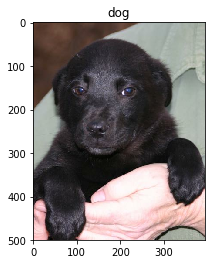

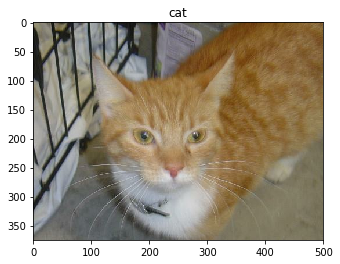

In [10]:
# লেবেল সহ ছবি দেখি
get_label_name = info.features['label'].int2str
for image, label in cat_test.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))
  image_ = image

একটা জিনিস বোঝা গেল যে, আমাদের এখানে যে দুটো ছবি দেখছি, সেগুলোর সাইজ একরকম নয়। আমাদের নতুন মডেলে ডাটা ফিড করানোর আগে ইমেজ পিক্সেল ভ্যালুগুলোকে আমরা এক রকম করে নিয়ে আসবো। তার পাশাপাশি আগের মত ছবির পিক্সেল ভ্যালুগুলোকে নর্মালাইজ করে নেব যাতে এটা ০ থেকে ১ এর মধ্যে থাকে। আমাদের এই কাজে ইমেজগুলোকে ১০০, ১০০ পিক্সেল সাইজ করে নেব tf.image.resize থেকে। ছবির সাইজ ছোট করে ফেলার কারণে অ্যাকুরেসি কমলেও ট্রেনিং এর স্পিড বাড়বে। এখানে tf.cast(image, tf.float32)ব্যবহার করছি তার দরকারি ডাটা টাইপে কনভার্ট করে সেটাকে নর্মালাইজ করব ২৫৫ দিয়ে ভাগ দিয়ে। আমাদের দরকার মতো ডাটা সেটকে ‘শাফল’ করে নেই যাতে ঠিকমতো ব্যাচ হিসেবে ট্রেইন করানো যায়। আমাদের এখানে ব্যাচ সাইজ হবে ৬৪ করে। 

In [0]:
IMAGE_SIZE = 100
def pre_process_image(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.0
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

In [0]:
TRAIN_BATCH_SIZE = 64
cat_train = cat_train.map(pre_process_image).shuffle(1000).repeat().batch(TRAIN_BATCH_SIZE)
cat_valid = cat_valid.map(pre_process_image).repeat().batch(1000)

আমরা যেহেতু টেন্সর-ফ্লো ২.x এর জন্য ‘কেরাস’ এপিআই ব্যবহার করছি, সে কারণে আমরা একটা নতুন কনসেপ্ট দেখাতে চাই এখানে। জিনিসটাকে ‘কনভলিউশন নিউরাল নেটওয়ার্কে’ ব্যবহার করতে দেখেছি অনেক জায়গায়। একই জিনিস, লেখার ধারণা কিছুটা ভিন্ন। আমরা এটাকে বলছি একটা “হেড মডেল” যার মধ্যে স্ট্যান্ডার্ড কনভলিউশন, ম্যাক্স পুলিং অপারেশন চলবে, শেষে আমরা বলছি কনভলিউশন এবং ম্যাক্স পুলিং এর পাশাপাশি ‘নরমালাইজেশন’ এবং ‘অ্যাক্টিভেশন’ ফাংশন হিসেবে রেল্যু থাকবে। দেখুন, এটা কিন্তু আমাদের মডেলের শুরুর অংশ, যাকে হেড বলেছি।

আমরা এখানে ব্যবহার করছি সিকুয়েন্সিয়াল মডেল, আগের মতো।

In [0]:
head = tf.keras.Sequential()
head.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(32, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(64, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

## ‘স্ট্যান্ডার্ড ফুললি কানেক্টেড ক্লাসিফায়ার’ যোগ করছি শেষে

এখন আমাদের নেটওয়ার্কের শেষ অংশ মানে ‘ব্যাক এন্ড’ যোগ করতে হবে যাতে ঠিকমতো ক্লাসিফিকেশন করতে পারি। কি দরকার শুরুতে? ফ্ল্যাটেন, আর শেষে ১ নিউরন মানে হয় বিড়াল নাহলে কুকুর। শুরুতেই আমাদের ‘স্ট্যান্ডার্ড ফুললি কানেক্টেড ক্লাসিফায়ার’ যোগ করছি। এই মুহূর্তে আমরা ‘ড্রপআউট’ নিয়ে চিন্তা করছি না। আবারো বলছি, যেহেতু শেষ লেয়ারে মাত্র দুটো ক্লাস বিড়াল অথবা কুকুর সে কারনে আমাদের শেষ আউটপুট লেয়ার যেটা ‘ডেন্স’ অথবা ‘ফুললি কানেক্টেড’ যার মধ্যে একটা ‘সিগময়েড অ্যাক্টিভেশন’ ফাংশন থাকবে শেষ নোড এ। আমাদের কাজকে ভালো অ্যাক্যুরেসি দেবার জন্য আউটপুট ক্লাসিফিকেশনে দুটো ১০০ করে নোড যুক্ত করেছি সেই ডেন্স লেয়ারে। এখন আমাদের হেড মডেল এবং স্ট্যান্ডার্ড ক্লাসিফায়ারকে (ব্যাক এন্ড) যোগ করার পালা।

In [0]:
standard_classifier = tf.keras.Sequential()
standard_classifier.add(layers.Flatten())
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.Dense(1))
standard_classifier.add(layers.Activation('sigmoid'))

In [0]:
standard_classifier_with_do = tf.keras.Sequential()
standard_classifier_with_do.add(layers.Flatten())
standard_classifier_with_do.add(layers.BatchNormalization())
standard_classifier_with_do.add(layers.Dense(100))
standard_classifier_with_do.add(layers.Activation('relu'))
standard_classifier_with_do.add(layers.Dropout(0.5))
standard_classifier_with_do.add(layers.BatchNormalization())
standard_classifier_with_do.add(layers.Dense(100))
standard_classifier_with_do.add(layers.Activation('relu'))
standard_classifier_with_do.add(layers.Dense(1))
standard_classifier_with_do.add(layers.Activation('sigmoid'))

In [0]:
average_pool = tf.keras.Sequential()
average_pool.add(layers.AveragePooling2D())
average_pool.add(layers.Flatten())
average_pool.add(layers.Dense(1, activation='sigmoid'))

## টেন্সর-ফ্লো ‘কল ব্যাক’

আমাদের মডেল ভালো করছে কিনা সেটা দেখার জন্য টেন্সর-ফ্লো ‘কল ব্যাক’ ফিচার অ্যাড করেছি। এখন আমাদের এই স্ট্যান্ডার্ড মডেলকে ট্রেইন করার পালা। আমাদের লসে ব্যবহার করছি ‘বাইনারি এনট্রপি’ কারণ আমাদের এখানে দুটো বাইনারি ক্লাস।

In [0]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))]

#### হেড এবং ব্যাকএড যোগ করছি

এখন আমরা গ্লোবাল অ্যাভারেজ পুলিং এর অংশ যোগ করি। এরপরে আমরা বলছি পুল মডেলটা কি? দেখুন এখানে মডেল হেড এবং এভারেজ পুল যোগ করে দিয়েছি। এখন দেখি তাদের অ্যাকুরেসি রেজাল্ট কেমন? দুটোকে আমরা পাশাপাশি দেখতে পারছি। 

In [0]:
pool_model = tf.keras.Sequential([
    head, 
    average_pool
])

In [0]:
pool_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))]

In [21]:
pool_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=7, 
               validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

Train for 363 steps, validate for 10 steps
Epoch 1/7
  1/363 [..............................] - ETA: 42:54 - loss: 0.6995 - accuracy: 0.5625WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227417). Check your callbacks.


  2/363 [..............................] - ETA: 22:44 - loss: 0.6653 - accuracy: 0.5859WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221347). Check your callbacks.


363/363 [==============================] - 114s 314ms/step - loss: 0.5237 - accuracy: 0.7367 - val_loss: 0.5953 - val_accuracy: 0.6546
Epoch 2/7
363/363 [==============================] - 112s 309ms/step - loss: 0.4194 - accuracy: 0.8079 - val_loss: 0.4636 - val_accuracy: 0.7803
Epoch 3/7
363/363 [==============================] - 113s 311ms/step - loss: 0.3755 - accuracy: 0.8321 - val_loss: 0.4606 - val_accuracy: 0.7834
Epoch 4/7
363/363 [==============================] - 112s 307ms/step - loss: 0.3426 - accuracy: 0.8514 - val_loss: 0.5421 - val_accuracy: 0.7807
Epoch 5/7
363/363 [==============================] - 113s 311ms/step - loss: 0.3129 - accuracy: 0.8642 - val_loss: 0.3638 - val_accuracy: 0.8435
Epoch 6/7
363/363 [==============================] - 113s 312ms/step - loss: 0.2851 - accuracy: 0.8797 - val_loss: 0.4453 - val_accuracy: 0.7946
Epoch 7/7
363/363 [==============================] - 113s 311ms/step - loss: 0.2660 - accuracy: 0.8882 - val_loss: 0.3654 - val_accuracy: 0.

এখানে কি দেখছি? আমাদের ট্রেনিং অ্যাকুরেসি ভালো হলেও এটা ‘ওভার ফিটিং’ এর মধ্যে চলে যাচ্ছে যখন আমরা ভ্যালিডেশন ডাটাসেট ব্যবহার করছি। ভ্যালিডেশন ডাটাসেট এর অ্যাকুরেসি ৮০তে আটকে থাকলেও যেহেতু ‘লস’ বাড়ছে, যা সিগন্যাল দিচ্ছে একটা ‘ওভার ফিটিং’ এর হিসেব।

In [0]:
standard_model = tf.keras.Sequential([
    head, 
    standard_classifier
])

In [0]:
standard_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))]

আমরা দেখতে পাচ্ছি স্ট্যান্ডার্ড ‘ফুললি কানেক্টেড নেটওয়ার্ক’ থেকে গ্লোবাল অ্যাভারেজ পুলিং মডেল ভালো করছে ৭ নাম্বার ইপক থেকে। যদিও ট্রেনিং অ্যাকুরেসি ‘ফুললি কানেক্টেড মডেল’ থেকে কম তবে সেটা ‘ওভার ফিটিং’ এর জন্য। তবে সেটাকে কমিয়ে আনা হয়েছে ‘গ্যাপ’ মডেলে। এখানে একটু ড্রপ আউট নিয়ে আলাপ করি। 

In [0]:
standard_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=10, validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

Train for 363 steps, validate for 10 steps
Epoch 1/10
  1/363 [..............................] - ETA: 23:59 - loss: 0.5959 - accuracy: 0.7812WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.516208). Check your callbacks.


363/363 [==============================] - 109s 301ms/step - loss: 0.3202 - accuracy: 0.8583 - val_loss: 0.7674 - val_accuracy: 0.7365
Epoch 2/10
363/363 [==============================] - 114s 314ms/step - loss: 0.1821 - accuracy: 0.9277 - val_loss: 0.6157 - val_accuracy: 0.7983
Epoch 3/10
363/363 [==============================] - 116s 318ms/step - loss: 0.1142 - accuracy: 0.9551 - val_loss: 0.6290 - val_accuracy: 0.8165
Epoch 4/10
363/363 [==============================] - 114s 315ms/step - loss: 0.0798 - accuracy: 0.9712 - val_loss: 0.5423 - val_accuracy: 0.8347
Epoch 5/10
363/363 [==============================] - 118s 326ms/step - loss: 0.0604 - accuracy: 0.9774 - val_loss: 0.5532 - val_accuracy: 0.8404
Epoch 6/10
363/363 [==============================] - 116s 320ms/step - loss: 0.0468 - accuracy: 0.9832 - val_loss: 0.5066 - val_accuracy: 0.8481
Epoch 7/10
171/363 [=============>................] - ETA: 38s - loss: 0.0467 - accuracy: 0.9827

## ‘ড্রপ আউট’

আমরা দেখতে পাচ্ছি স্ট্যান্ডার্ড ‘ফুললি কানেক্টেড নেটওয়ার্ক’ থেকে গ্লোবাল অ্যাভারেজ পুলিং মডেল ভালো করছে ৭ নাম্বার ইপক থেকে। যদিও ট্রেনিং অ্যাকুরেসি ‘ফুললি কানেক্টেড মডেল’ থেকে কম তবে সেটা ‘ওভার ফিটিং’ এর জন্য। তবে সেটাকে কমিয়ে আনা হয়েছে ‘গ্যাপ’ মডেলে। এখানে একটু ড্রপ আউট নিয়ে আলাপ করি। 

আমাদের মডেলে যখন ‘ওভার ফিটিং’ হয়, তখন বিশেষ করে নিউরাল নেটওয়ার্কে রেগুলারাইজেশন টেকনিক (লস কম আর অ্যাক্যুরেসি বাড়ানো) হিসেবে ‘ড্রপ আউট’ ব্যবহার করা হয়। ‘ড্রপ আউট’ হচ্ছে আমাদের মডেল ঠিক মতো কাজ করছে কিনা সেটা দেখার জন্য সেটার নিউরনগুলোর মধ্যে যে সংযোগ আছে সেগুলোর মধ্যে কিছু কিছু জায়গায় দৈবচয়নের ভিত্তিতে সংযোগ বিচ্ছিন্ন করে দেওয়া হয়। ফলে মডেলকে যদি ভালো পারফর্ম করতে হয় তখন সেই সংযোগ ছাড়াই নিউরনগুলো ঠিকমতো আউটপুট দিতে পারছে কিনা সেটা দেখা যায় শেষে। মডেল ঠিকমতো জেনারালাইজ করতে পারছে কিনা সে কারণে কিছু কিছু নিউরন বন্ধ করে দিলেও যদি মডেলের ‘নেট গেইন’ ভালো থাকে তাহলে বোঝা যায় যে মডেল ঠিকমতো জেনারেলাইজড হয়েছে, মানে ট্রেনিং ডাটার সাথে একদম মিলে যায়নি, মানে ওভার ফিটিং কম।

In [0]:
standard_model_with_do = tf.keras.Sequential([
    head, 
    standard_classifier_with_do
])

In [0]:
standard_model_with_do.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))]

আমাদের ফাইনাল মডেলে ০.৫ এর একটা ‘ড্রপ আউট’ লেয়ার যোগ করছি ওভার ফিটিং থেকে বাঁচার জন্য।

In [0]:
standard_model_with_do.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=7, validation_data=cat_valid, validation_steps=10,
                           callbacks=callbacks)

In [0]:
%tensorboard --logdir log/

<img src="https://raw.githubusercontent.com/raqueeb/deep_learning_book/master/assets/ten10.PNG"> চিত্রঃ স্ট্যান্ডার্ড কনভল্যুশনাল নিউরাল নেটওয়ার্ক / 'গ্যাপ' মডেলের অ্যাক্যুরেসি এবং লস 

<img src="https://raw.githubusercontent.com/raqueeb/deep_learning_book/master/assets/ten12.PNG"> চিত্রঃ ট্রেনিং এবং ভ্যালিডেশন ফাইলের হিসেব 


শেষে আমরা এই তিন মডেল থেকে কি দেখলাম? এই তিনটা মডেলে কিন্তু একই ‘কনভলিউশনাল ফ্রন্ট এন্ড’ ছিল, তবে আমরা দেখছি সবচেয়ে ভালো ভ্যালিডেশন অ্যাকুরেসি এসেছে ৭ ইপক ট্রেনিংএর পরে আমাদের ‘গ্যাপ’ মডেলে। যদিও ‘ড্রপ আউট’ কিছুটা মডেলকে বুষ্ট দিয়েছে ভ্যালিডেশন অ্যাকুরেসিতে তবে আমরা যেটা বুঝেছি, স্ট্যান্ডার্ড ‘সিএনএন’ এর সাথে ‘গ্লোবাল এভারেজ পুলিং’ ভালো কাজ করে। 

## গ্যাপ মডেলকে (সেভ) স্টোর করি

In [0]:
pool_model.save('gap_model.h5')

## নতুন একটা ইমেজকে প্রেডিকশন করতে পারবো?

ব্যাচ নিয়ে একটা সমস্যা হতে পারে। একটা ছবি কি পারবে?

In [0]:
# নতুন একটা ইমেজ প্রেডিকশন করি
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

img_path = 'sample_image.jpg'
img = image.load_img(img_path, target_size=(200, 200))
img

In [0]:
# ইমেজটাকে লোড করি
def load_image(filename):
	# ইন্টারনেট থেকে sample_image.jpg নামালাম
	img = load_img(filename, target_size=(100, 100))
	# অ্যারেতে কনভার্ট করলাম
	img = img_to_array(img)
	# মডেলের জন্য রি-শেপিং 
	img = img.reshape(1, 100, 100, 3)
	return img

# লোড করার পর প্রেডিক্ট করি
def run_example():
	# ইমেজ লোড করি
	img = load_image('sample_image.jpg')
	# মডেল লোড করি
	model = load_model('gap_model.h5')
	# ক্লাস প্রেডিক্ট করি
	result = model.predict(img)
	print(result[0])
 
# run_example() চালাই
run_example()

বলতে হবে - কি ভুল হলো?